In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os
import gzip
import lasagne
from lasagne import layers
from nolearn.lasagne import NeuralNet
from lasagne.updates import sgd
from utility import *
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")
/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['log', 'colors']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * f

In [2]:
pylab.rcParams['figure.figsize'] = (15, 9)
sys.setrecursionlimit(10000)
conv2d1_filters_numbers = 8
conv2d1_filters_size = 9
conv2d2_filters_numbers = 8
conv2d2_filters_size = 1
conv2d3_filters_numbers = 1
conv2d3_filters_size = 5

down_sample_ratio = 16
learning_rate = 0.00001
epochs = 100
HiC_max_value = 100

In [3]:
low_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_down16_chr19_22.npy.gz', "r")) * down_sample_ratio
high_resolution_samples = np.load(gzip.GzipFile('../data/GM12878_replicate_original_chr19_22.npy.gz', "r"))
low_resolution_samples, high_resolution_samples, cache = loadData(40, 40, 28, 28, root="../../")
low_resolution_samples = low_resolution_samples.reshape(-1, 1, 40, 40)
high_resolution_samples = high_resolution_samples.reshape(-1, 1, 40, 40)

Starting to load data...
expected:  17 17
actual: 17 17 289
expected:  17 17
actual: 17 17 289
expected:  17 16
actual: 17 16 272
expected:  17 16
actual: 17 16 272
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 13
actual: 17 13 221
expected:  17 12
actual: 17 12 204
expected:  17 12
actual: 17 12 204
expected:  17 11
actual: 17 11 187
expected:  17 11
actual: 17 11 187
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 10
actual: 17 10 170
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 9
actual: 17 9 153
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 7
actual: 17 7 119
expected:  17 6
act

finished loading data


In [4]:
print(low_resolution_samples.shape)
print(high_resolution_samples.shape)

(20022, 1, 40, 40)
(20022, 1, 40, 40)


In [5]:
sample_size = low_resolution_samples.shape[-1]
padding = conv2d1_filters_size + conv2d2_filters_size + conv2d3_filters_size - 3
half_padding = padding // 2
output_length = sample_size - padding
print(sample_size)
print(output_length)

40
28


In [6]:
Y = high_resolution_samples[:, 0, half_padding:(sample_size-half_padding), half_padding:(sample_size-half_padding)]
Y = Y.reshape(Y.shape[0], -1)
X = low_resolution_samples

In [7]:
print(X.shape)
print(Y.shape)

(20022, 1, 40, 40)
(20022, 784)


In [8]:
net1 = NeuralNet(
    layers=[
        ('input', layers.InputLayer),
        ('conv2d1', layers.Conv2DLayer),
        ('conv2d2', layers.Conv2DLayer),
        ('conv2d3', layers.Conv2DLayer),
        ('output_layer', layers.FlattenLayer),
        ],
    input_shape=(None, 1, sample_size, sample_size),
    conv2d1_num_filters=conv2d1_filters_numbers,
    conv2d1_filter_size = (conv2d1_filters_size, conv2d1_filters_size),
    conv2d1_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d1_W=lasagne.init.GlorotUniform(),
    conv2d2_num_filters=conv2d2_filters_numbers,
    conv2d2_filter_size = (conv2d2_filters_size, conv2d2_filters_size),
    conv2d2_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_num_filters=conv2d3_filters_numbers,
    conv2d3_nonlinearity=lasagne.nonlinearities.rectify,
    conv2d3_filter_size = (conv2d3_filters_size, conv2d3_filters_size),
    update=sgd,
    update_learning_rate = learning_rate,
    regression=True,
    max_epochs= epochs,
    verbose=1,
    )

In [9]:
net1.fit(X, Y)

/home/bzr0014/anaconda3/envs/tensorGpu/lib/python3.6/site-packages/lasagne/layers/conv.py:489: UserWarning: The `image_shape` keyword argument to `tensor.nnet.conv2d` is deprecated, it has been renamed to `input_shape`.
  border_mode=border_mode)


# Neural Network with 929 learnable parameters

## Layer information

  #  name          size
---  ------------  -------
  0  input         1x40x40
  1  conv2d1       8x32x32
  2  conv2d2       8x32x32
  3  conv2d3       1x28x28
  4  output_layer  784

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  ------
      1     2.07144     1.88166    1.10086  16.96s
      2     2.06867     1.87912    1.10087  16.95s
      3     2.06571     1.87642    1.10088  16.95s
      4     2.06252     1.87355    1.10086  16.97s
      5     2.05903     1.87040    1.10085  16.95s
      6     2.05520     1.86692    1.10085  16.95s
      7     2.05082     1.86279    1.10094  17.01s
      8     2.04523     1.85749    1.10107  17.01s
      9     2.03747     1.84948    1.10164  16.99s
     10     2.02508     1.83428    1.10402  17.00s
     11     2.00141     1.80311    1.10998  17.02s
     12     1.95675     1.75146    1.11721  17.03s
     13     1.89394     1.69192    1

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7f8e584d80f0>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7f8e584d80b8>,
     check_input=True,
     conv2d1_W=<lasagne.init.GlorotUniform object at 0x7f8e57406cf8>,
     conv2d1_filter_size=(9, 9),
     conv2d1_nonlinearity=<function rectify at 0x7f8e3dd76378>,
     conv2d1_num_filters=8, conv2d2_filter_size=(1, 1),
     conv2d2_nonlinearity=<function rectify at 0x7f8e3dd76378>,
     conv2d2_num_filters=8, conv2d3_filter_size=(5, 5),
     conv2d3_nonlinearity=<function rectify at 0x7f8e3dd76378>,
     conv2d3_num_filters=1, custom_scores=None,
     input_shape=(None, 1, 40, 40),
     layers=[('input', <class 'lasagne.layers.input.InputLayer'>), ('conv2d1', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2d2', <class 'lasagne.layers.conv.Conv2DLayer'>), ('conv2d3', <class 'lasagne.layers.conv.Conv2DLayer'>), ('output_layer', <class 'lasagne.layers.shap

In [10]:
output_model_name = '../model/test_model'

f = open(output_model_name + '.net', 'wb')

pickle.dump(net1,f,protocol=pickle.HIGHEST_PROTOCOL)
f.close()

In [11]:
predicted = net1.predict(low_resolution_samples)

In [12]:
print(predicted.shape)
print(Y.shape)
print("Loss: ", np.sum((predicted - Y)**2))

(20022, 784)
(20022, 784)
Loss:  8824501.642531069


(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


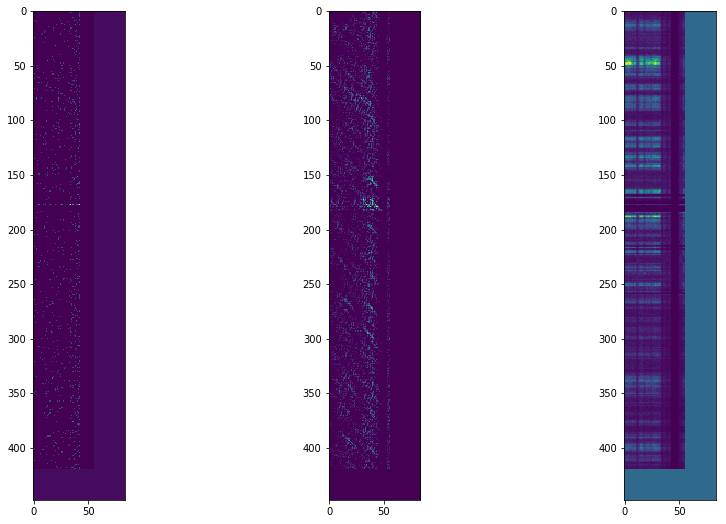

(16, 4, 28, 28)
shape:  (448, 112)
(16, 4, 28, 28)
(16, 4, 28, 28)


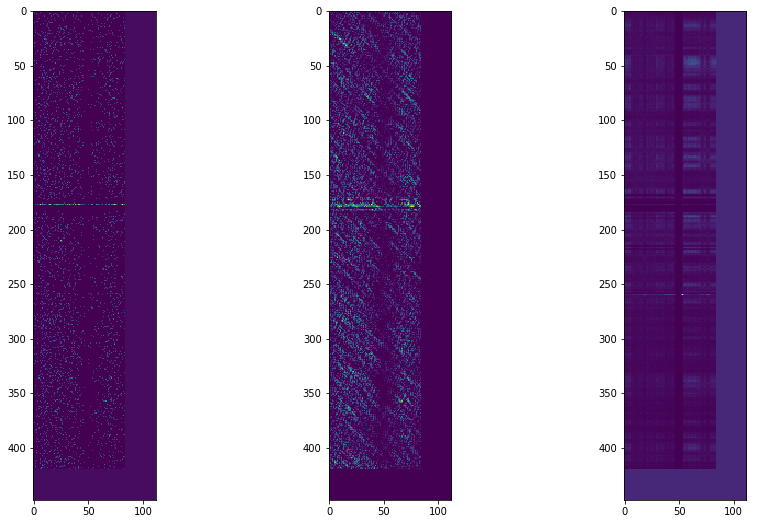

(16, 2, 28, 28)
shape:  (448, 56)
(16, 2, 28, 28)
(16, 2, 28, 28)


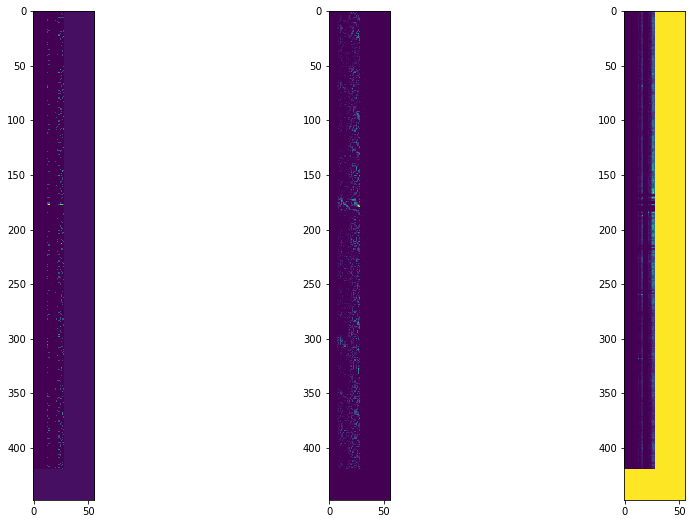

(16, 3, 28, 28)
shape:  (448, 84)
(16, 3, 28, 28)
(16, 3, 28, 28)


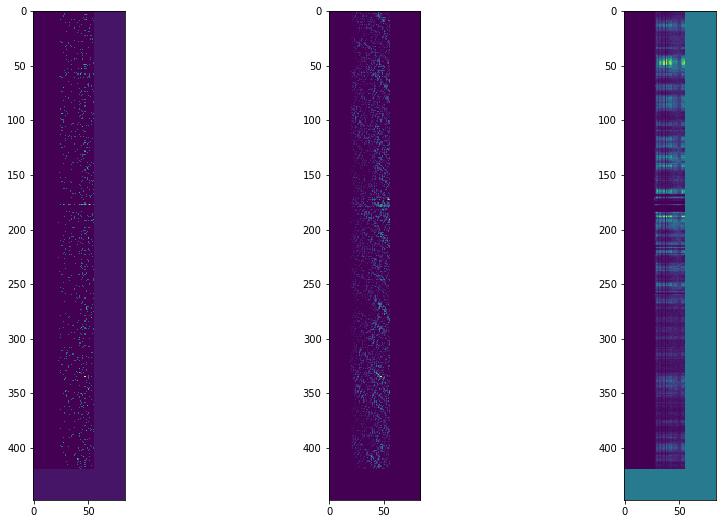

(16, 10, 28, 28)
shape:  (448, 280)
(16, 10, 28, 28)
(16, 10, 28, 28)


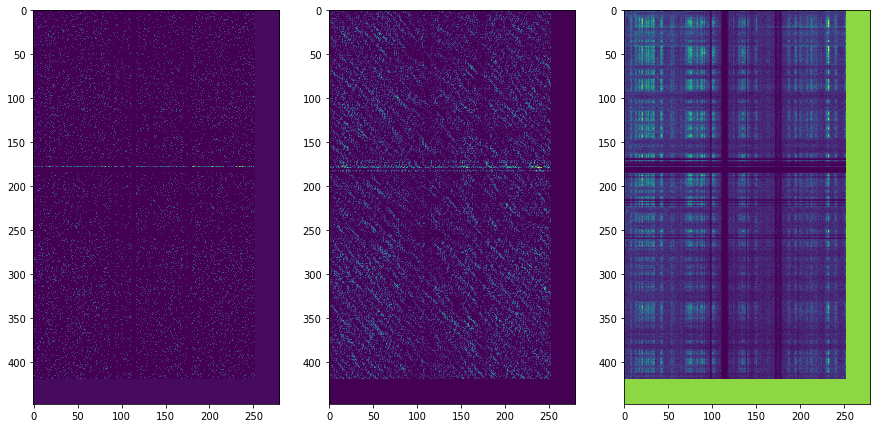

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


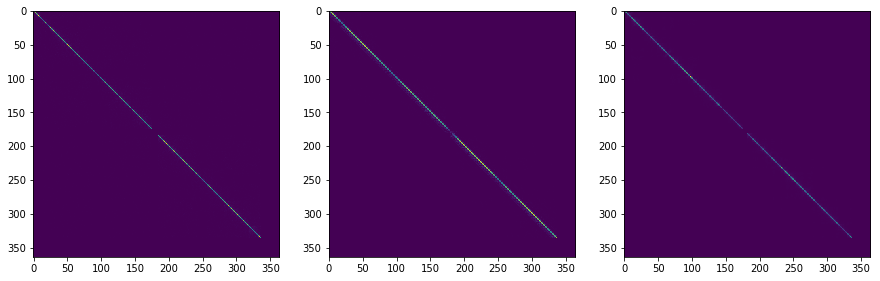

(13, 13, 28, 28)
shape:  (364, 364)
(13, 13, 28, 28)
(13, 13, 28, 28)


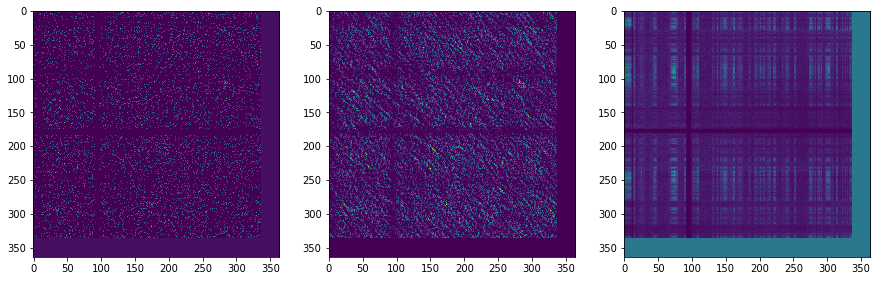

(13, 12, 28, 28)
shape:  (364, 336)
(13, 12, 28, 28)
(13, 12, 28, 28)


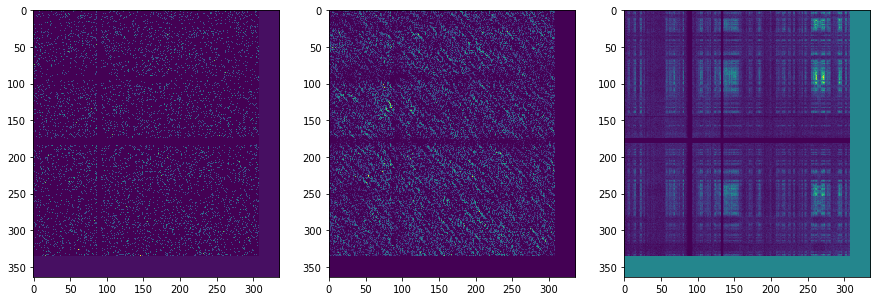

(13, 11, 28, 28)
shape:  (364, 308)
(13, 11, 28, 28)
(13, 11, 28, 28)


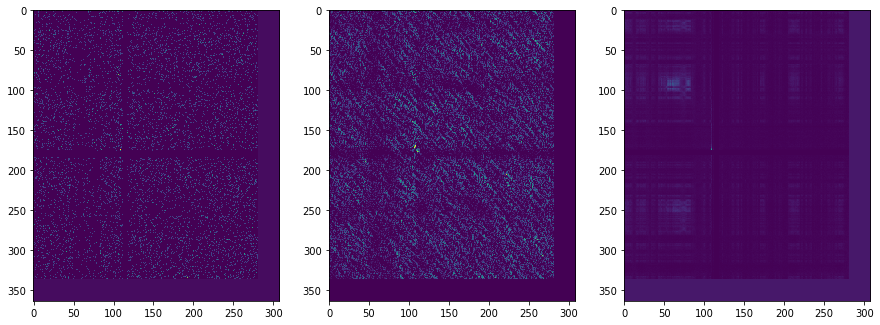

(13, 10, 28, 28)
shape:  (364, 280)
(13, 10, 28, 28)
(13, 10, 28, 28)


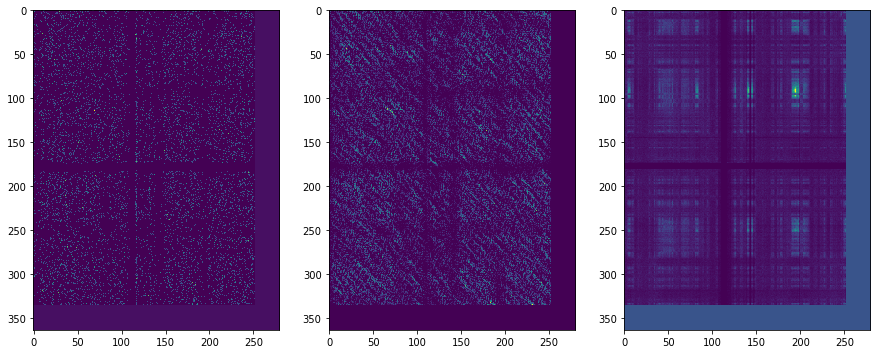

In [13]:
cacheIndex = 1
def mardas(cache, predicted, cacheIndex):
    sum = 0
    for i in range(cacheIndex):
       sum += cache[i][0] 
    N, cacheLow, cacheHigh = cache[cacheIndex]
    a1, a2, a3, a4, a5, a6, a7, a8, a9, a10 = cacheLow
    assert N == a9 * a10
    mout = predicted[sum:sum+N].reshape(a9, a10, 28, 28)
    #print(mout.shape )
    #mout = low_resolution_samples[:289, 0, 6:34, 6:34].reshape(17, 17, 28, 28)
    print(mout.shape )
    out = np.zeros((a9*28, a10*28))
    for i in range(a9-1):
        for j in range(a10-1):
            out[i*28:(i+1)*28, j*28:(j+1)*28] = mout[i, j]
    return out
#for cacheIndex in range(len(cache)):
for cacheIndex in range(40, 50):
    out0 = low_resolution_samples[:, 0, 6:34, 6:34]
    out0 = mardas(cache, out0, cacheIndex)
    print("shape: ", out0.shape)
    out1 = mardas(cache, predicted, cacheIndex)
    out2 = mardas(cache, Y, cacheIndex)
    ax = plt.subplot(1, 3, 1)
    ax.imshow(out0)   
    ax = plt.subplot(1, 3, 2)
    ax.imshow(out1)
    ax = plt.subplot(1, 3, 3)
    ax.imshow(out2)
    plt.show()